Qiitaでの解説記事はこちら<br>
「【機械学習】ディープラーニング フレームワークChainerを試しながら解説してみる。」<br>
http://qiita.com/kenmatsu4/items/7b8d24d4c5144a686412
<br>
<br>
chainer ver: chainer-1.3.1

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_mldata
from chainer import cuda, Variable, FunctionSet, optimizers
import chainer.functions  as F
import sys

plt.style.use('ggplot')

In [2]:
# 確率的勾配降下法で学習させる際の１回分のバッチサイズ
batchsize = 100

# 学習の繰り返し回数
n_epoch   = 20

# 中間層の数
n_units   = 1000

# MNISTの手書き数字データのダウンロード
# #HOME/scikit_learn_data/mldata/mnist-original.mat にキャッシュされる
print 'fetch MNIST dataset'
mnist = fetch_mldata('MNIST original')
# mnist.data : 70,000件の784次元ベクトルデータ
mnist.data   = mnist.data.astype(np.float32)
mnist.data  /= 255     # 0-1のデータに変換

# mnist.target : 正解データ（教師データ）
mnist.target = mnist.target.astype(np.int32)

fetch MNIST dataset


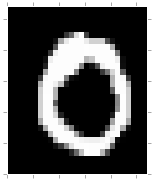

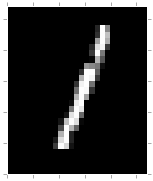

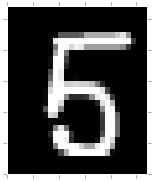

In [3]:
# 手書き数字データを描画する関数
def draw_digit(data):
    size = 28
    plt.figure(figsize=(2.5, 3))

    X, Y = np.meshgrid(range(size),range(size))
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(X, Y, Z)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

    plt.show()

draw_digit(mnist.data[5])
draw_digit(mnist.data[12345])
draw_digit(mnist.data[33456])

In [4]:
# 学習用データを N個、検証用データを残りの個数と設定
N = 60000
x_train, x_test = np.split(mnist.data,   [N])
y_train, y_test = np.split(mnist.target, [N])
N_test = y_test.size

# Prepare multi-layer perceptron model
# 多層パーセプトロンモデルの設定
# 入力 784次元、出力 10次元
model = FunctionSet(l1=F.Linear(784, n_units),
                    l2=F.Linear(n_units, n_units),
                    l3=F.Linear(n_units, 10))

# Neural net architecture
# ニューラルネットの構造
def forward(x_data, y_data, train=True):
    x, t = Variable(x_data), Variable(y_data)
    h1 = F.dropout(F.relu(model.l1(x)),  train=train)
    h2 = F.dropout(F.relu(model.l2(h1)), train=train)
    y  = model.l3(h2)
    # 多クラス分類なので誤差関数としてソフトマックス関数の
    # 交差エントロピー関数を用いて、誤差を導出
    return F.softmax_cross_entropy(y, t), F.accuracy(y, t)

# Setup optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)

epoch 1
train mean loss=0.277826743207, accuracy=0.916283333451
test  mean loss=0.115146953391, accuracy=0.964300007224
epoch 2
train mean loss=0.137200674197, accuracy=0.958083336155
test  mean loss=0.0858141334643, accuracy=0.973400005698
epoch 3
train mean loss=0.108558719674, accuracy=0.966783339381
test  mean loss=0.0742363627507, accuracy=0.978600008488
epoch 4
train mean loss=0.0922474473327, accuracy=0.97160000821
test  mean loss=0.0772527058572, accuracy=0.977100009322
epoch 5
train mean loss=0.0826306873979, accuracy=0.973833342691
test  mean loss=0.0813153728829, accuracy=0.975600007772
epoch 6
train mean loss=0.0779127888529, accuracy=0.976016675433
test  mean loss=0.0638860616562, accuracy=0.981000006199
epoch 7
train mean loss=0.0709229506341, accuracy=0.977783342699
test  mean loss=0.0664793714813, accuracy=0.980700005889
epoch 8
train mean loss=0.0671543211432, accuracy=0.978933343887
test  mean loss=0.062101596217, accuracy=0.982700009942
epoch 9
train mean loss=0.0619

[]

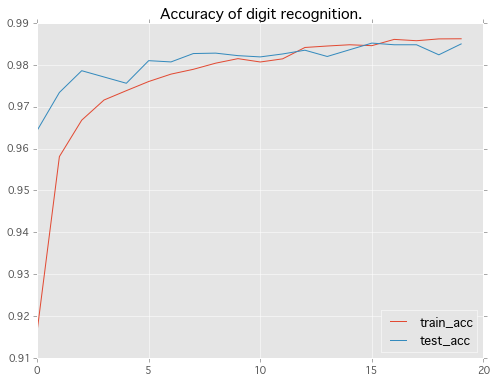

In [5]:
train_loss = []
train_acc  = []
test_loss = []
test_acc  = []

l1_W = []
l2_W = []
l3_W = []

# Learning loop
for epoch in xrange(1, n_epoch+1):
    print 'epoch', epoch

    # training
    # N個の順番をランダムに並び替える
    perm = np.random.permutation(N)
    sum_accuracy = 0
    sum_loss = 0
    # 0〜Nまでのデータをバッチサイズごとに使って学習
    for i in xrange(0, N, batchsize):
        x_batch = x_train[perm[i:i+batchsize]]
        y_batch = y_train[perm[i:i+batchsize]]

        # 勾配を初期化
        optimizer.zero_grads()
        # 順伝播させて誤差と精度を算出
        loss, acc = forward(x_batch, y_batch)
        # 誤差逆伝播で勾配を計算
        loss.backward()
        optimizer.update()
        sum_loss     += float(cuda.to_cpu(loss.data)) * batchsize
        sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

    # 訓練データの誤差と、正解精度を表示
    print 'train mean loss={}, accuracy={}'.format(sum_loss / N, sum_accuracy / N)

    train_loss.append(sum_loss / N)
    train_acc.append(sum_accuracy / N)

    # evaluation
    # テストデータで誤差と、正解精度を算出し汎化性能を確認
    sum_accuracy = 0
    sum_loss     = 0
    for i in xrange(0, N_test, batchsize):
        x_batch = x_test[i:i+batchsize]
        y_batch = y_test[i:i+batchsize]

        # 順伝播させて誤差と精度を算出
        loss, acc = forward(x_batch, y_batch, train=False)

        sum_loss     += float(cuda.to_cpu(loss.data)) * batchsize
        sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

    # テストデータでの誤差と、正解精度を表示
    print 'test  mean loss={}, accuracy={}'.format(sum_loss / N_test, sum_accuracy / N_test)
    test_loss.append(sum_loss / N_test)
    test_acc.append(sum_accuracy / N_test)

    # 学習したパラメーターを保存
    l1_W.append(model.l1.W)
    l2_W.append(model.l2.W)
    l3_W.append(model.l3.W)

# 精度と誤差をグラフ描画
plt.figure(figsize=(8,6))
plt.plot(range(len(train_acc)), train_acc)
plt.plot(range(len(test_acc)), test_acc)
plt.legend(["train_acc","test_acc"],loc=4)
plt.title("Accuracy of digit recognition.")
plt.plot()


<function matplotlib.pyplot.show>

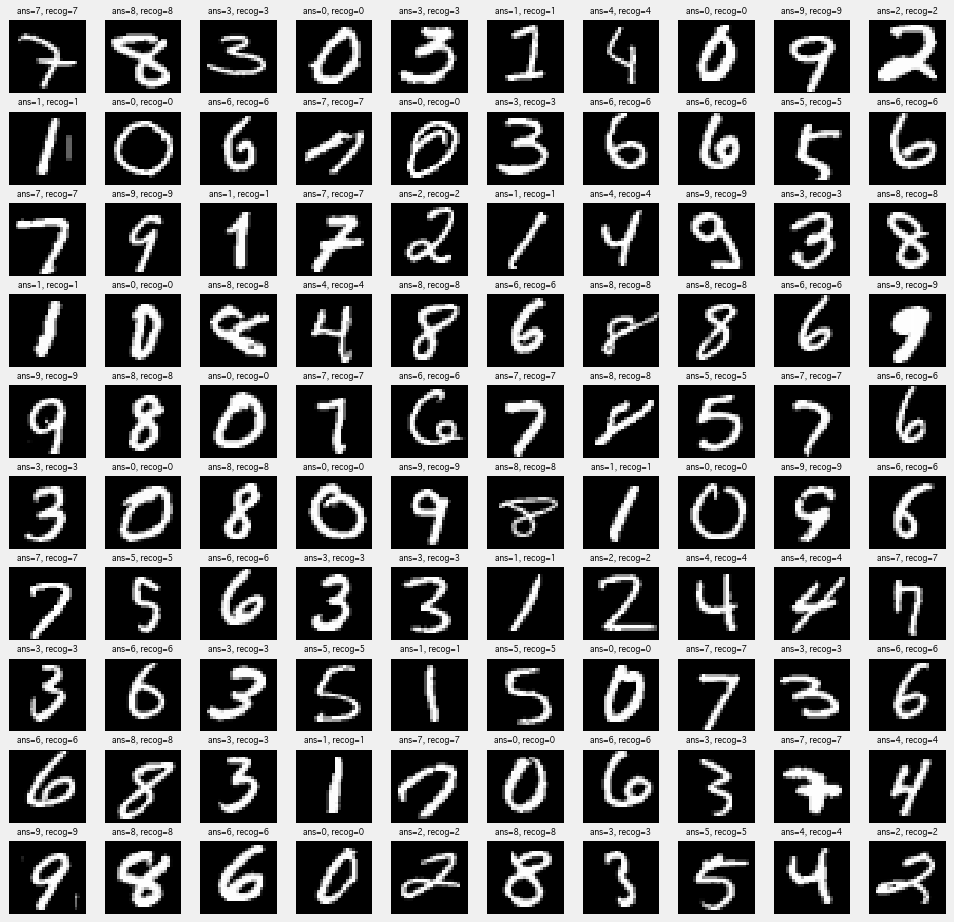

In [6]:
# Show Predict Result
plt.style.use('fivethirtyeight')
def draw_digit3(data, n, ans, recog):
    size = 28
    plt.subplot(10, 10, n)
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(Z)
    plt.title("ans=%d, recog=%d"%(ans,recog), size=8)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")


plt.figure(figsize=(15,15))

cnt = 0
for idx in np.random.permutation(N)[:100]:
    # Forwarding for prediction
    xxx = x_train[idx].astype(np.float32)
    h1 = F.dropout(F.relu(model.l1(Variable(xxx.reshape(1,784)))),  train=False)
    h2 = F.dropout(F.relu(model.l2(h1)), train=False)
    y  = model.l3(h2)
    cnt+=1
    draw_digit3(x_train[idx], cnt, y_train[idx], np.argmax(y.data))
plt.show

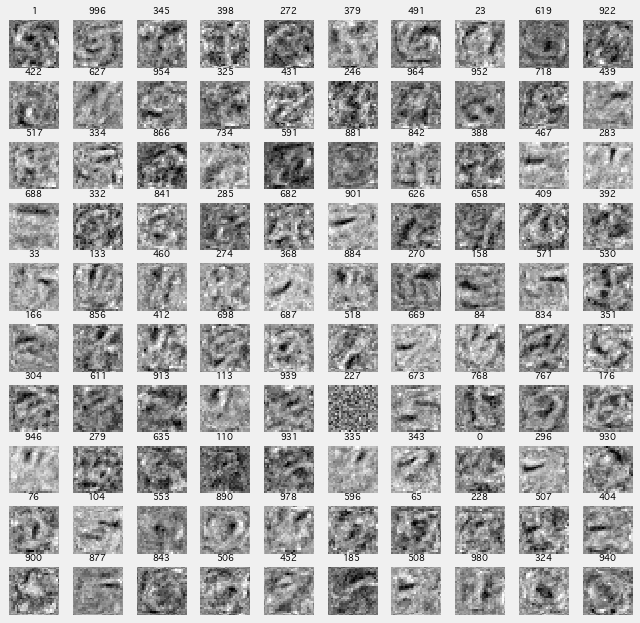

In [7]:
# layer 1
def draw_digit2(data, n, i):
    size = 28
    plt.subplot(10, 10, n)
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,size-1)
    plt.ylim(0,size-1)
    plt.pcolor(Z)
    plt.title("%d"%i, size=9)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

plt.figure(figsize=(10,10))
cnt = 1
for i in np.random.permutation(1000)[:100]:
    draw_digit2(l1_W[len(l1_W)-1][i], cnt, i)
    cnt += 1

plt.show()

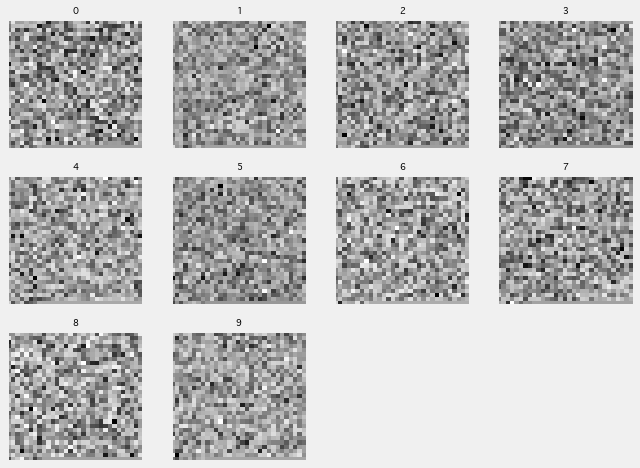

In [9]:
# layer 3
def draw_digit4(data, n, i):
    size = 32
    plt.subplot(4, 4, n)
    data = np.r_[data,np.zeros(24)]
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,size-1)
    plt.ylim(0,size-1)
    plt.pcolor(Z)
    plt.title("%d"%i, size=9)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

plt.figure(figsize=(10,10))
cnt = 1
for i in range(10):
    draw_digit3(l3_W[len(l3_W)-1][i], cnt, i)
    cnt += 1

plt.show()

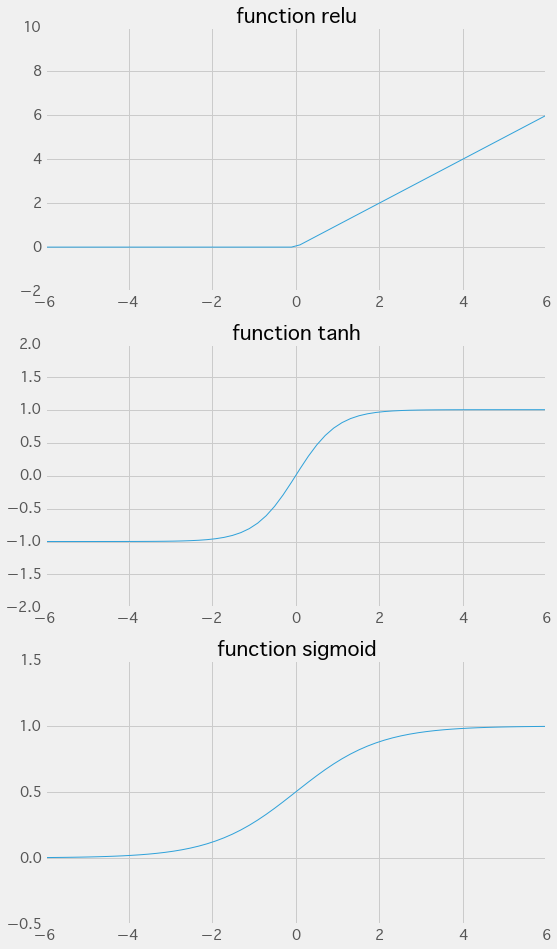

In [10]:
# Draw activation functions
x_data = np.linspace(-10, 10, 100, dtype=np.float32)
x = Variable(x_data)

plt.figure(figsize=(8,15))

i=0
for func, y_lim in zip([F.relu, F.tanh, F.sigmoid], [(-2,10),(-2,2),(-.5,1.5)]):
    y = func(x)
    plt.subplot(311+i)
    i += 1
    plt.title(str(func).split('at')[0].replace('<',''))
    plt.ylim(y_lim)
    plt.xlim(-6,6)
    plt.plot(x.data, y.data, lw=1)

plt.show()